In [1]:
import pandas as pd
import numpy as np
import re
import math
import tldextract
from urllib.parse import urlparse
from pathlib import Path

In [2]:
DATA_PROC = Path("../data/processed")
DATA_FEAT = Path('../data/features')
DATA_FEAT.mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_parquet(DATA_PROC / 'urls.parquet')

In [6]:
def count_digits(s):
    return sum(c.isdigit() for c in s)

In [7]:
def count_special_chars(s):
    return sum(not c.isalnum() for c in s)

In [13]:
def url_entropy(s):
    """Compute Shannon entropy of a string (URL)."""
    # Count frequency of each character
    freq = {}
    for c in s:
        freq[c] = freq.get(c, 0) + 1
    length = len(s)
    # Compute Shannon entropy
    ent = -sum((f/length) * math.log2(f/length) for f in freq.values())
    return ent

In [14]:
df["url_length"] = df["url"].apply(len)
df["num_digits"] = df["url"].apply(count_digits)
df["num_special_chars"] = df["url"].apply(count_special_chars)
df["entropy"] = df["url"].apply(url_entropy)

In [10]:
def extract_domain(url):
    ext = tldextract.extract(url)
    return ext.domain

In [11]:
def extract_suffix(url):
    ext = tldextract.extract(url)
    return ext.suffix

In [12]:
df["domain"] = df["url"].apply(extract_domain)
df["suffix"] = df["url"].apply(extract_suffix)

In [15]:
df["domain_length"] = df["domain"].apply(len)
df["suffix_length"] = df["suffix"].apply(len)

In [16]:
df["num_subdirs"] = df["url"].apply(lambda x: urlparse(x).path.count("/"))
df["num_params"] = df["url"].apply(lambda x: urlparse(x).query.count("&") + (1 if urlparse(x).query else 0))
df["num_fragments"] = df["url"].apply(lambda x: 1 if urlparse(x).fragment else 0)
df["has_https"] = df["url"].apply(lambda x: int(urlparse(x).scheme == "https"))

In [17]:
features = df.drop(columns=["url", "domain", "suffix"])
features.to_parquet(DATA_FEAT / "url_features.parquet", index=False)
features.shape

(641119, 11)

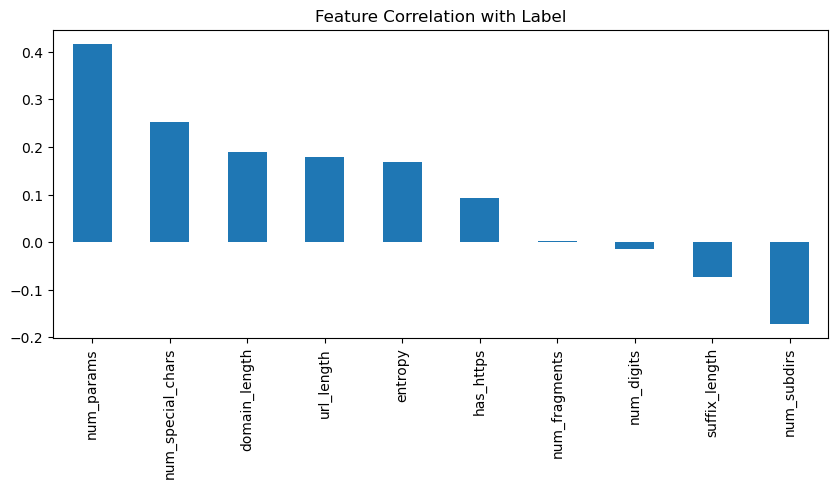

In [18]:
import matplotlib.pyplot as plt


corr = features.drop(columns="label").corrwith(features["label"]).sort_values(ascending=False)
corr.plot(kind="bar", figsize=(10,4), title="Feature Correlation with Label")
plt.show()